# 0.0. IMPORTS

In [7]:
import pickle
import psycopg2
import warnings

import numpy                 as np
import pandas                as pd
import seaborn               as sns
import scikitplot            as skplt
import scipy.stats           as ss
import matplotlib.pyplot     as plt
import imblearn.combine      as c

from sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model       import LogisticRegression, SGDClassifier
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler

from lightgbm                   import LGBMClassifier
from xgboost                    import XGBClassifier
from IPython.display            import Image

from boruta                     import BorutaPy

%matplotlib inline
warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [95]:
def get_tables(table):
    '''This functions receives a list with table names to be loaded from the database'''
    # to create a df to store all loaded dfs
    df_tab = pd.DataFrame()
    
    # iterate over the list of tables, load each one, take the column names and create a final df
    for tab in table:
        sql = 'SELECT * FROM pa004.{}'.format(tab)
        cur.execute(sql)
        cols = [desc[0] for desc in cur.description] # saving the column names
        data = []
        for i in cur:
            data.append(i)
        df = pd.DataFrame(data, columns = cols)
        
        if 'id' in df_tab:
            df_tab = df_tab.merge(df, how = 'left', left_on = 'id', right_on = 'id')
        else:
            df_tab = df.copy()
    return df_tab

def num_descriptive(num_attributes):
    # Central Tendendy: mean, median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # Dispersion: std, min, max, range, skewness, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
    d4 = pd.DataFrame(num_attributes.quantile( .25 )).T
    d5 = pd.DataFrame(num_attributes.quantile( .75 )).T
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    d8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

    # concatenating them and printing
    m = pd.concat( [d2, d3, d6, d4,  ct2, d5, ct1, d1, d7, d8] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', '25%','median','75%', 'mean', 'std', 'skewness', 'kurtosis'] # renaming columns
    return m

def cramer_v(x, y):
    '''This functions calculates the Cramér V, a measure of association between two nominal variables'''
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / min(kcorr - 1, rcorr - 1))

    cm = pd.crosstab(x, y).matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

## 0.2. Collecting the Data

In [35]:
# creating parameters  to access the database
params = dict(
    database='',
    user='',
    password='',
    host='',
    port=
)
# creating the connection
conn = psycopg2.connect(**params)

# creating the cursor
cur = conn.cursor()

**Let's find out how many tables there are**

In [36]:
sql = "select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)'"
cur.execute(sql)
tables = cur.fetchall()
table_names = []
for table, database in enumerate(tables, start=1):
    table_names.append(database[0])
    print(f'Table {table}: {database[0]}')

Table 1: users
Table 2: vehicle
Table 3: insurance


**Now, let's load them all and store them in a single dataframe.**

In [32]:
#df_raw =  get_tables(table_names) # fucntion defined in section 0.1: Helper Functions
#cur.close()
#conn.close()

#pickle.dump( df_raw, open( '../data/df_raw.pkl', 'wb') ) # saving the df as pickle format
#df_raw = pickle.load(open('../data/df_raw.pkl', 'rb'))

Splitting the data with stratified sampling in order to keep response proportion in both train and test datasets

In [158]:
splitting = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in splitting.split(df_raw, df_raw['response']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)

pickle.dump( train_dataset, open( '../data/train_dataset.pkl', 'wb') )
pickle.dump( test_dataset, open( '../data/test_dataset.pkl', 'wb') )

In [3]:
df_raw = pickle.load(open('../data/temp/train_dataset.pkl', 'rb'))

In [4]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,153813,Female,23,34.0,152.0,1,< 1 Year,Yes,0,32451.0,278,1
1,43216,Male,24,36.0,152.0,1,< 1 Year,Yes,0,37183.0,137,0
2,335441,Female,21,50.0,160.0,1,< 1 Year,No,1,56038.0,279,0
3,76325,Female,23,3.0,124.0,1,< 1 Year,Yes,0,38646.0,67,0
4,323690,Female,41,28.0,124.0,1,1-2 Year,Yes,0,37008.0,172,1


# 1.0. STEP 1: DATA DESCRIPTION

In [40]:
df1 = df_raw.copy()

# deletting df_raw
#del df_raw

## 1.1. Data Dimensions

In [49]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 342998
Number of Columns: 12


## 1.2. Data Types

In [164]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342998 entries, 0 to 342997
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    342998 non-null  int64  
 1   gender                342998 non-null  object 
 2   age                   342998 non-null  int64  
 3   region_code           342998 non-null  float64
 4   policy_sales_channel  342998 non-null  float64
 5   driving_license       342998 non-null  int64  
 6   vehicle_age           342998 non-null  object 
 7   vehicle_damage        342998 non-null  object 
 8   previously_insured    342998 non-null  int64  
 9   annual_premium        342998 non-null  float64
 10  vintage               342998 non-null  int64  
 11  response              342998 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 31.4+ MB


## 1.3. Checking for Missing Values

In [165]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4. Checking the Target Balance


In [166]:
df1['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

So, the data is very imbalanced.

## 1.5. Descriptive Statistics

In [167]:
num_attributes = df1[['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage']]
cat_attributes = df1.drop(['id','age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage'], axis = 1)

### 1.5.1 Numerical Attributes

In [168]:
num_descriptive(num_attributes) # fucntion defined in section 0.1: Helper Functions

,attributes,min,max,range,25%,median,75%,mean,std,skewness,kurtosis
0,age,20.0,85.0,65.0,25.0,36.0,49.0,38.827900,15.517065,0.671923,-0.567571
1,region_code,0.0,52.0,52.0,15.0,28.0,35.0,26.395349,13.230572,-0.115460,-0.866988
2,policy_sales_channel,1.0,163.0,162.0,29.0,135.0,152.0,112.037770,54.204455,-0.899940,-0.971009
3,annual_premium,2630.0,540165.0,537535.0,24405.0,31680.0,39411.0,30581.030884,17220.631696,1.713080,31.874216
4,vintage,10.0,299.0,289.0,82.0,154.0,227.0,154.346043,83.674152,0.002822,-1.200926


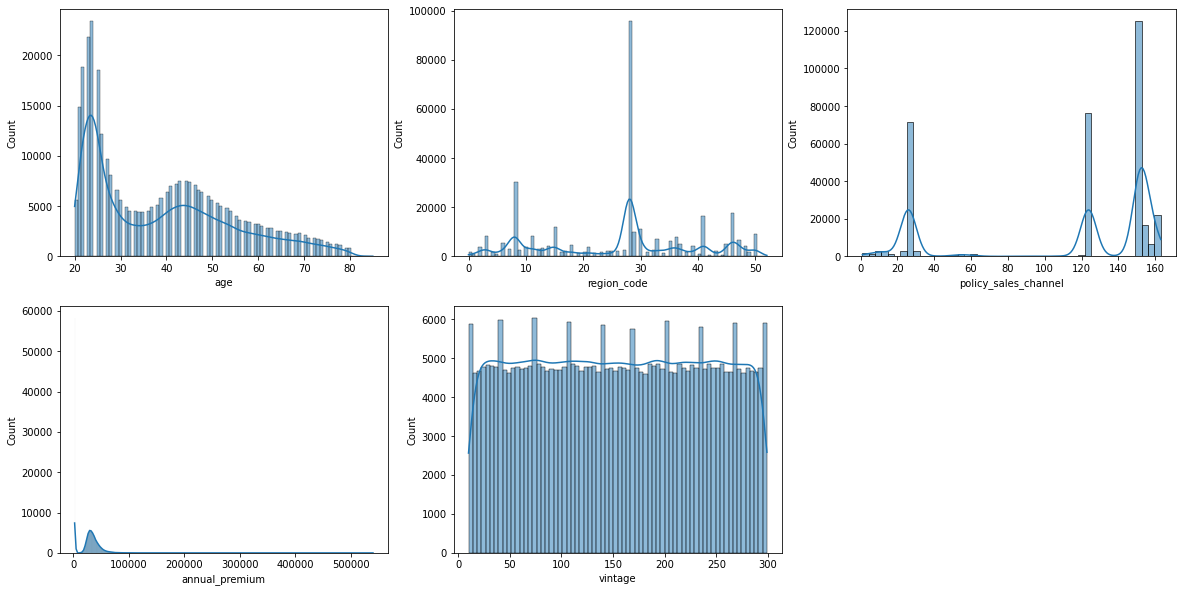

In [169]:
plt.subplots( figsize = ( 20,10 ) )
plt.subplot(2, 3, 1);
sns.histplot(num_attributes['age'], kde=True)

plt.subplot(2, 3, 2);
sns.histplot(num_attributes['region_code'], kde=True)

plt.subplot(2, 3, 3);
sns.histplot(num_attributes['policy_sales_channel'], kde=True)

plt.subplot(2, 3, 4);
sns.histplot(num_attributes['annual_premium'], kde=True)

plt.subplot(2, 3, 5);
sns.histplot(num_attributes['vintage'], kde=True);

**Conclusions**:
- `age` seems not to have any inconsistent value (minimum of 20 and maximum of 85).
- `annual_premium` shows a large range, meaning that there're customers who paid too little and too much to the company
- Skewness:
    + all variables have a low skewness. 
    + `region_code` and `policy_sales_channel` have negative skewness, meaning that the observations are slightly concentrated on the the right side of the distribution;
    + `age` and `annual_premium` have a low positive skewness, meaning that the observations are slightly concentrated on the left side of the distribuition.
- Kurtosis:
    + except by `annual_premium`, all fariables have a low kurtosis coefficient, meaning that there are fewer values close to the mean (Platykurtic). `annual_premium`, otherwise, have a very leptokurtic distribution, meaning that there are more values close to the mean.

### 1.5.2. Categorical Attributes

In [149]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender                2
driving_license       2
vehicle_age           3
vehicle_damage        2
previously_insured    2
response              2
dtype: int64

In [141]:
# changing some numeric variables to object so the functions can works well
cat_attributes['driving_license'] = cat_attributes['driving_license'].map({1: 'yes', 0:'no' })
cat_attributes['previously_insured'] = cat_attributes['previously_insured'].map({1: 'yes', 0:'no' })
cat_attributes['response'] = cat_attributes['response'].map({1: 'yes', 0:'no' })

cat_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append
        corr_list.append(corr)
    
    corr_dict[ref] = corr_list

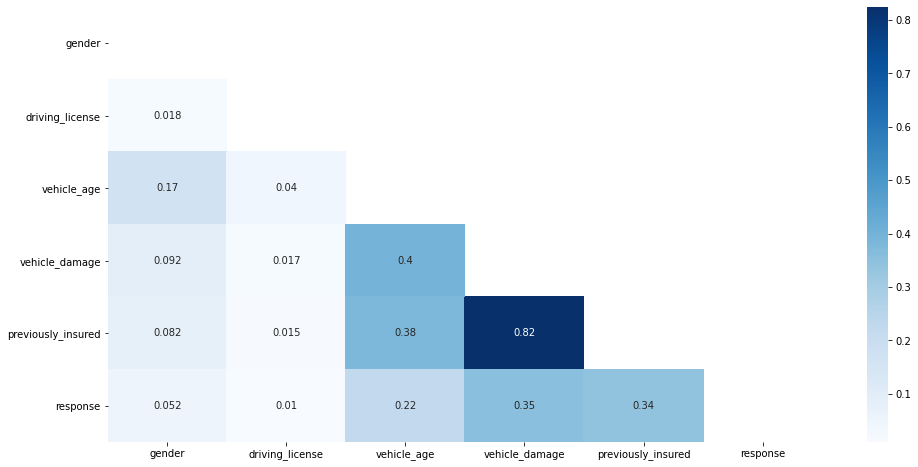

In [148]:
cat_corr = pd.DataFrame(corr_dict)
cat_corr = cat_corr.set_index(cat_corr.columns)
mask = np.zeros_like( cat_corr, dtype=np.bool )
mask[np.triu_indices_from( mask )] = True

plt.subplots( figsize = ( 16,8 ) )
sns.heatmap( cat_corr, cmap='Blues', mask = mask, annot=True)

# 2.0. STEP 2: FEATURE ENGINEERING AND HYPOTHESIS CREATION

In [41]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

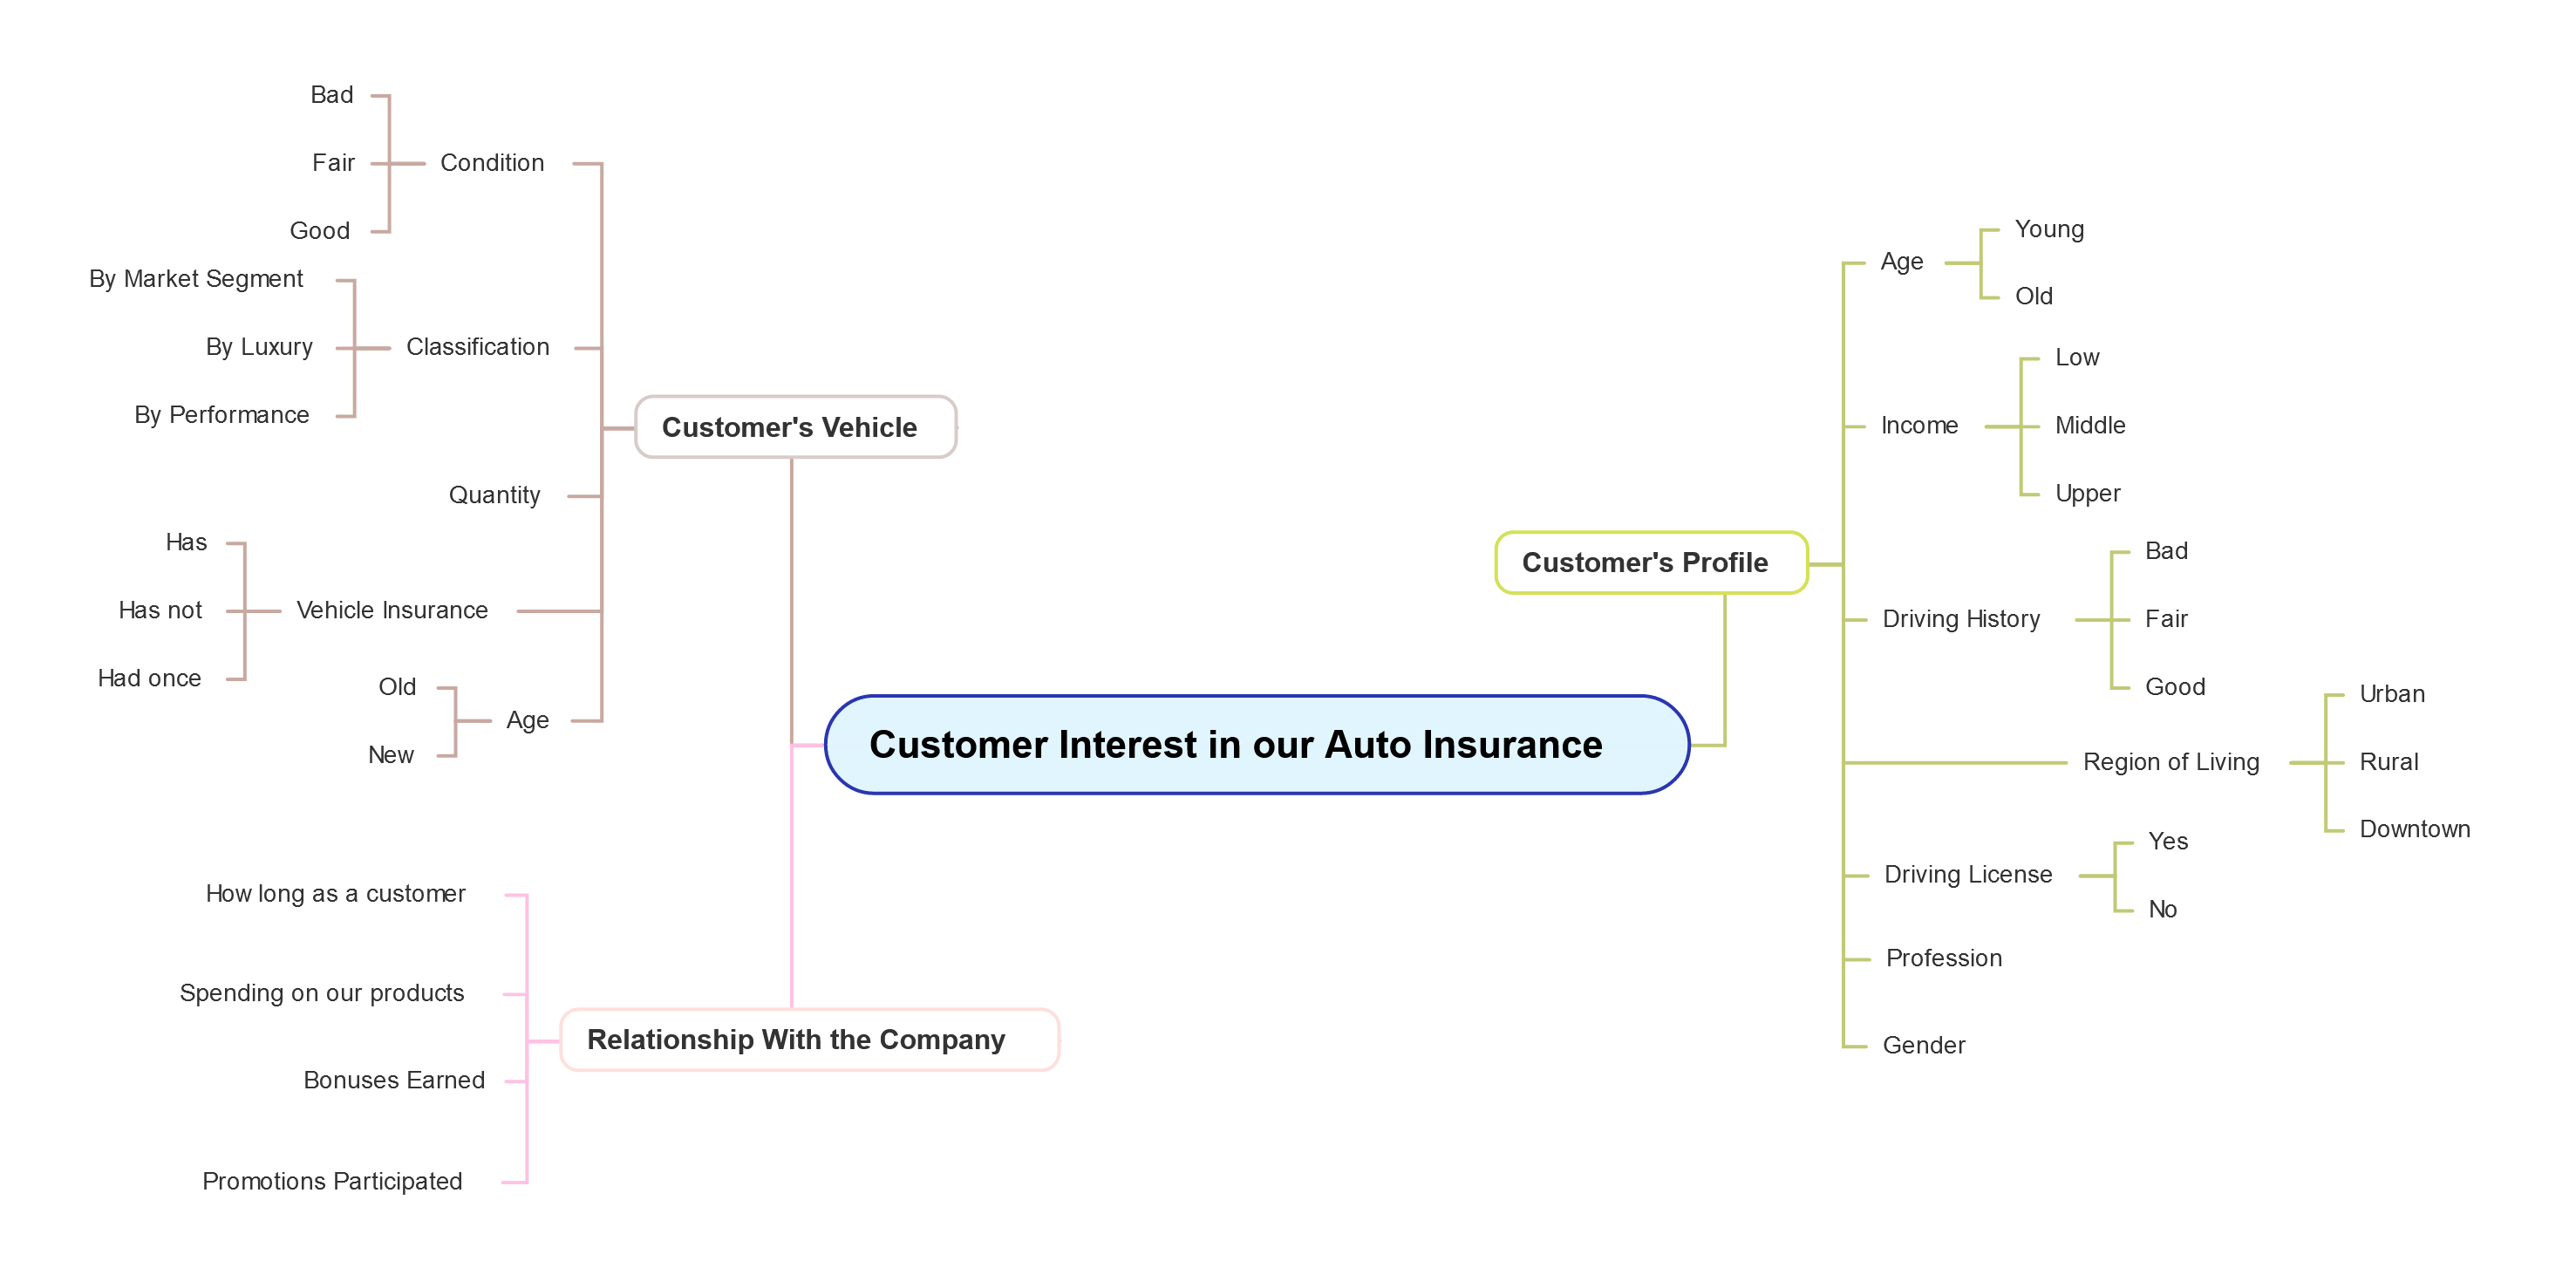

In [3]:
Image( '../imgs/mind_map.png' )

## 2.1. Business Hypothesis List

**1.** Among the customers interested in purchasing the insurance, there are more around the middle age.

**2.** The proportion of customers interested in purchasing the insurance is higher among those who have driving license.

**3.** At least 40% of customers who have had their vehicles damaged are interested in purchasing the insurance.

**4.** Among women, the proportion of customers interested in purchasing the insurance is at least 10% higher than the proportion among men.

**5.** Among customers over the age of 60, those who have a vehicle older than 2 years are more interested in purchase the insurance.

**6.** The proportion of customers interested in purchase the insurance is at least 10% higher among those who are customers for more than 6 months.

**7.** Customers who spent above the average in premiums are more interested in purchasing the insurance.

**8.** Customers who spent above the average in less time as a customer are more interested in purchasing the vehicle insurance. 

**9.** There are more customers interested in purchasing the insurance among those who have a vehicle newer than 1 year.

**10.** There are more customers interested in purchasing the insurance among those who have never had a vehicle insurance.

**11.** Customers from regions that have a higher mean in premium spending are more interested in purchasing the insurance.

## 2.4. Feature Engineering

To validate the H8, we need to create a new feature containing how much the customer spent with the health insurance in the agency over the period he/she is a customer (number of days the customer joined the company through the purchase of health insurance).

In [42]:
df2['premium_vintage'] = df2['annual_premium'] / df2['vintage']

Since vehicle insurance premium starts to increase around the age of 60 ([see here](https://www.valuepenguin.com/how-age-affects-auto-insurance-costs)), let's create a categorical variable containing whether the customer is older than 60 years or not. This new feature can get the interest of the 'after 60s' customers in purchasing the insurance.

In [43]:
df2['after_60'] = df2.apply( lambda x: 0 if x['age'] < 60 else 1, axis = 1)

In [9]:
df2['vintage_months'] = df2['vintage']/30

In [10]:
df2['vintage_age'] = df2['age']*365 / df2['vintage']

In [11]:
df2['region_premium'] = 0
for index, code in zip(df2.index, df2['region_code']):
    df2['region_premium'].iloc[index] = df2[df2['region_code'] == code]['annual_premium'].mean()

In [46]:
df2['policy_premium'] = 0
for index, code in zip(df2.index, df2['policy_sales_channel']):
    df2['policy_premium'].iloc[index] = df2[df2['policy_sales_channel'] == code]['annual_premium'].mean()

In [48]:
# saving the df as pickle format
pickle.dump( df2, open( '../data/df2.pkl', 'wb') ) 

## 2.5. Balancing Dataset: using SMOTE and TOMEKLINK

In [49]:
df21 = df2.copy()

In [50]:
df21[['male', 'female']] = pd.get_dummies(df21['gender'])
df21['vehicle_damage'] = df21['vehicle_damage'].map( {'Yes':1, 'No':0})
df21['vehicle_age'] = df21['vehicle_age'].map( {'< 1 Year':1, '1-2 Year':2, '> 2 Years':3})

df22 = df21.drop(['id', 'gender', 'response'], axis =1).copy()

In [51]:
ratio_balanced =  {0: 300959,
                   1:  7*42039}
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

In [52]:
# applying the sampler
X_smt, y_smt = smt.fit_resample( df22, df21['response'] )

In [53]:
# saving the balanced dataset into df21
df21 = X_smt.copy()
df21['gender'] = df21[['male', 'female']].idxmax(axis=1)
df21['response'] = y_smt

df2_balanced = df21.drop(['male', 'female'], axis = 1)

In [54]:
# saving the df as pickle format
pickle.dump( df2_balanced, open( '../data/df2_balanced.pkl', 'wb') ) 

# deleting variables 
#del df2, df21, df22, X_smt, y_smt 

# 3.0. STEP 3: DATA FILTERING

# 4.0. STEP 4: EXPLORATORY DATA ANALYSIS

In [6]:
df4 = pickle.load(open('../data/temp/df2.pkl', 'rb'))
df4_balanced = pickle.load(open('../data/temp/df2_balanced.pkl', 'rb'))

In [98]:
num_attributes = df4_balanced[['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage', 'premium_vintage',  'vintage_months', 'vintage_age', 'region_premium']].copy()
cat_attributes = df4_balanced.drop(['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage', 'premium_vintage',  'vintage_months', 'vintage_age', 'region_premium'], axis = 1)

## 4.1. Univariate Analysis

### 4.1.1. Response Variable Analysis

In [4]:
df4_balanced['response'].value_counts()

0    289461
1    282775
Name: response, dtype: int64

### 4.1.2. Numerical Variables Analysis (with the balanced dataset)

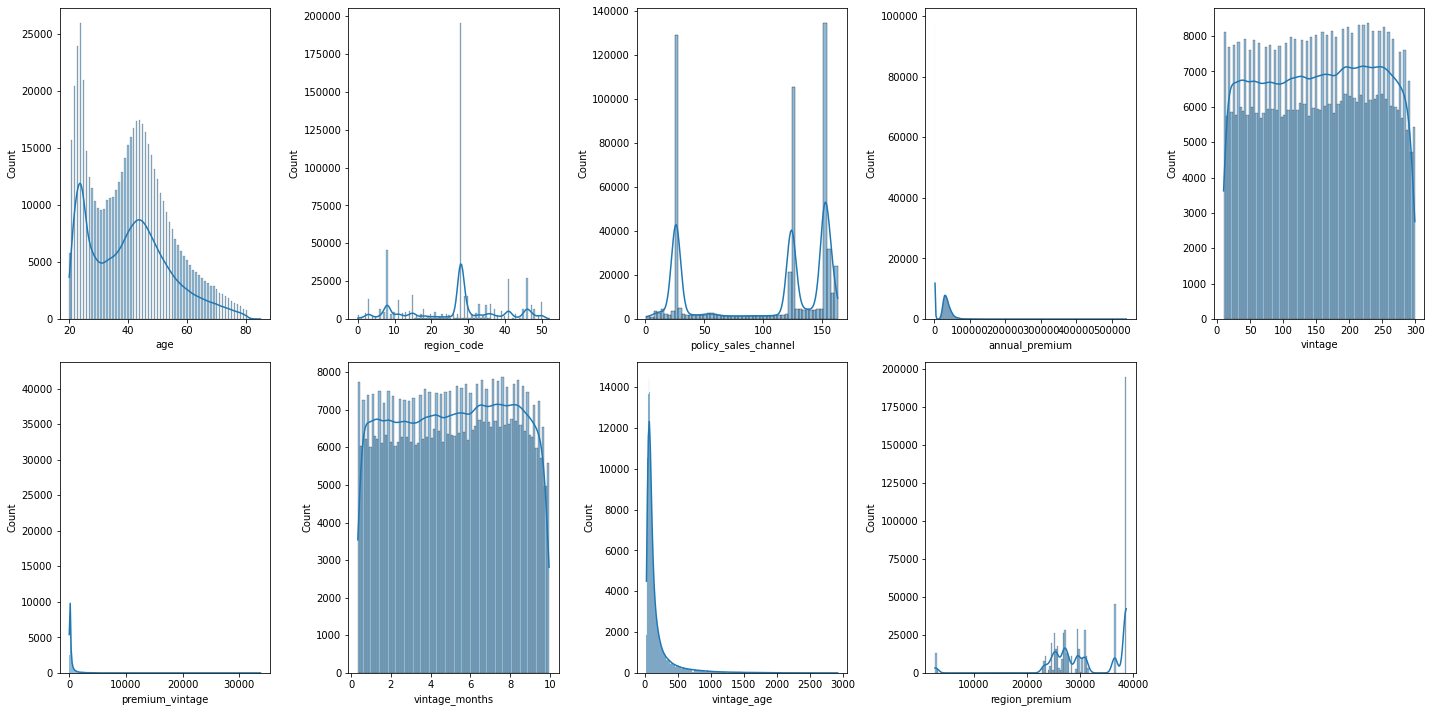

In [123]:
plt.subplots( figsize = ( 20,10 ) )
plt.subplot(2, 5, 1);
sns.histplot(num_attributes['age'], kde=True)

plt.subplot(2, 5, 2);
sns.histplot(num_attributes['region_code'], kde=True)

plt.subplot(2, 5, 3);
sns.histplot(num_attributes['policy_sales_channel'], kde=True)

plt.subplot(2, 5, 4);
sns.histplot(num_attributes['annual_premium'], kde=True)

plt.subplot(2, 5, 5);
sns.histplot(num_attributes['vintage'], kde=True)

plt.subplot(2, 5, 6);
sns.histplot(num_attributes['premium_vintage'], kde=True)

plt.subplot(2, 5, 7);
sns.histplot(num_attributes['vintage_months'], kde=True)

plt.subplot(2, 5, 8);
sns.histplot(num_attributes['vintage_age'], kde=True)

plt.subplot(2, 5, 9);
sns.histplot(num_attributes['region_premium'], kde=True)
plt.tight_layout();

### 4.1.3. Categorical Variables Analysis (with the balanced dataset)

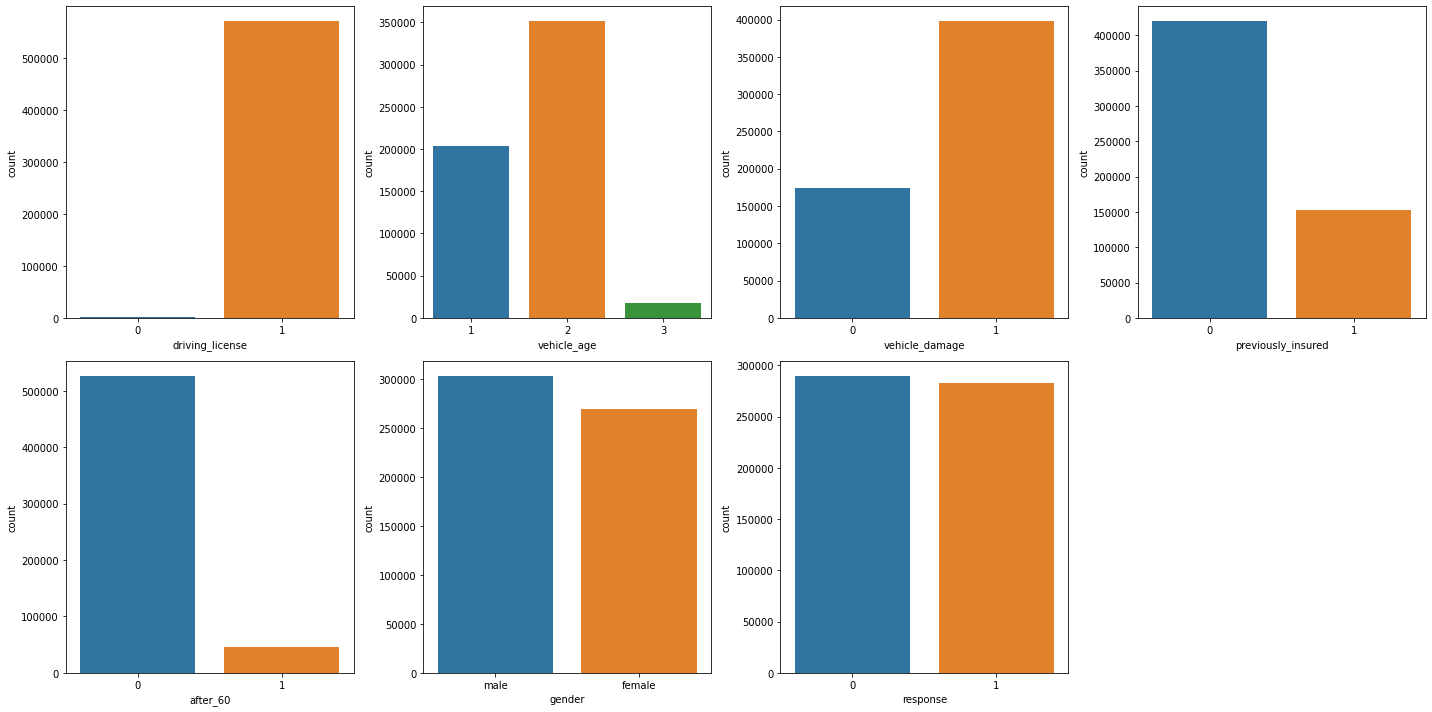

In [12]:
plt.subplots( figsize = ( 20,10 ) )
plt.subplot(2, 4, 1);
sns.countplot(cat_attributes['driving_license'])

plt.subplot(2, 4, 2);
sns.countplot(cat_attributes['vehicle_age'])

plt.subplot(2, 4, 3);
sns.countplot(cat_attributes['vehicle_damage'])

plt.subplot(2, 4, 4);
sns.countplot(cat_attributes['previously_insured'])

plt.subplot(2, 4, 5);
sns.countplot(cat_attributes['after_60'])

plt.subplot(2, 4, 6);
sns.countplot(cat_attributes['gender'])

plt.subplot(2, 4, 7);
sns.countplot(cat_attributes['response'])
plt.tight_layout();

## 4.2. Bivariate Analysis: Hypothesis Validation (with the imbalanced dataset)

### H1: Among the customers interested in purchasing the insurance, there are more around the middle age.
**<font color='green'>TRUE</font>**: customers between 35 and 55 years old are more interested in purchasing the insurance.<br>

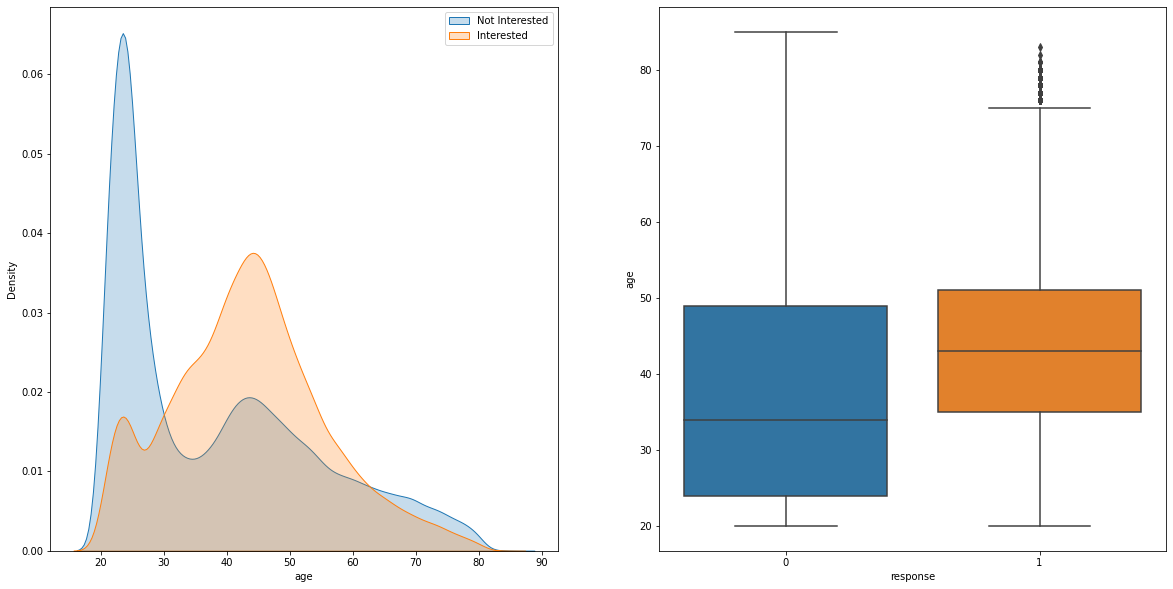

In [13]:
plt.figure(figsize = (20, 10))

plt.subplot(1,2,1)
sns.kdeplot(df4[df4['response'] == 0]['age'], fill = True, label = 'Not Interested')
sns.kdeplot(df4[df4['response'] == 1]['age'], fill = True, label = 'Interested')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot( y = 'age', x = 'response', data = df3);

Let's perform a statistical test to check if the average `age` between interested and not interested customers are equal. **Rejecting the null hypothesis (the two means are statistically equal), we could consider `age` relevant to determine the interest in purchasing the insurance**.

$$ H_0: \mu_a = \mu_b $$
$$ H_1: \mu_a ≠ \mu_b $$

In [14]:
# separating customers interested and not interested in purchasing the insurance
cus_not_interested = df3[df3['response'] == 0]['age'].to_list()
cus_interested = df3[df3['response'] == 1]['age'].to_list()

# calculating confidence interval for sample of customers age interested in purchasing the insurance
confidence_level = 0.95
degrees_freedom = len(cus_interested) - 1
sample_mean = np.mean(cus_interested)
sample_standard_error = ss.sem(cus_interested)
CI = ss.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
t2, p2 = ss.ttest_ind(cus_interested,cus_not_interested, equal_var = False)
print("t-test = " + str(t2))
print("p-value = " + str(p2))
print("Confidence Interval (95%) = " + str(CI))
print("Mean Age for Customers not Interested = " + str(np.mean(cus_not_interested)))

t-test = 79.42684277619554
p-value = 0.0
Confidence Interval (95%) = (43.31603578034733, 43.54906567306498)
Mean Age for Customers not Interested = 38.18470622244226


Since the p-value is lower than the alpha value, 0.05, and the mean age of patients not interested in purchasing the vehicle insurance is not between the confidence interval, we reject the null hypothesis that the two means are equal.

### H2: The proportion of customers interested in purchasing the insurance is higher among those who have driving license.
**<font color='red'>FALSE</font>**: the proportion of customers who have driving license interested in purchasing the insurance is higher than the proportion of customers who don't have it.<br>

In [16]:
# checking the balance of the feature
df4['driving_license'].value_counts(normalize = True)

1    0.997851
0    0.002149
Name: driving_license, dtype: float64

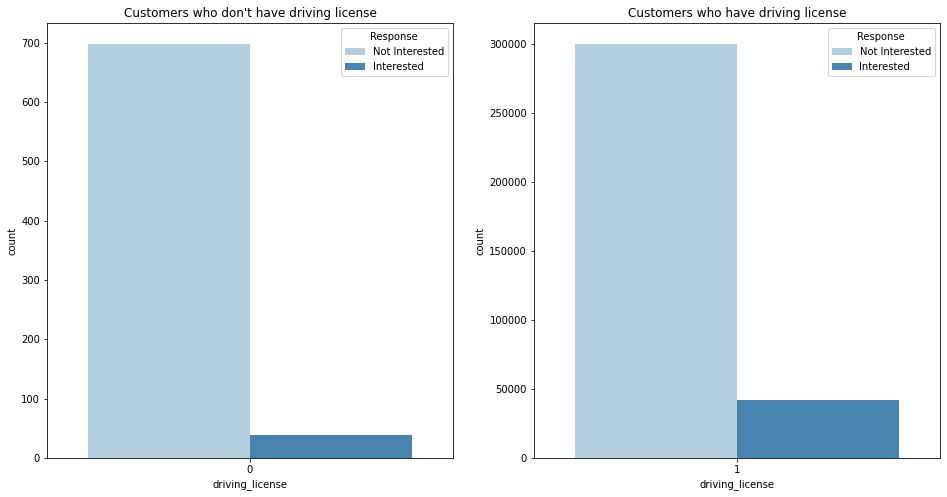

In [17]:
plt.figure(figsize = [16,8])
plt.subplot(1,2,1)
sns.countplot(x = 'driving_license', hue = 'response', data = df4[df4['driving_license'] == 0], palette = 'Blues')
plt.title('Customers who don\'t have driving license')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])

plt.subplot(1,2,2)
sns.countplot(x = 'driving_license', hue = 'response', data = df4[df4['driving_license'] == 1], palette = 'Blues')
plt.title('Customers who have driving license')
plt.legend(title='Response',labels = ['Not Interested', 'Interested']);

Let's take a better look at the proportion:

In [18]:
print('Percentage of customers without driving license who are interested in purchasing the insurance: {:.2f}%'.format(df4[df4['driving_license'] == 0]['response'].sum() / len(df4[df4['driving_license'] == 0])*100))
print('Percentage of customers with driving license who are interested in purchasing the insurance: {:.2f}%'.format(df4[df4['driving_license'] == 1]['response'].sum() / len(df4[df4['driving_license'] == 1])*100))

Percentage of customers without driving license who are interested in purchasing the insurance: 5.29%
Percentage of customers with driving license who are interested in purchasing the insurance: 12.27%


### H3: At least 40% of customers who have had their vehicles damaged are interested in purchasing the insurance.
**<font color='red'>FALSE</font>**: among customers who have had their vehicles damaged, about 23% are interested in purchasing the insurance. <br>

In [36]:
# checking the balance of the feature
df3['vehicle_damage'].value_counts(normalize = True)

Yes    0.505265
No     0.494735
Name: vehicle_damage, dtype: float64

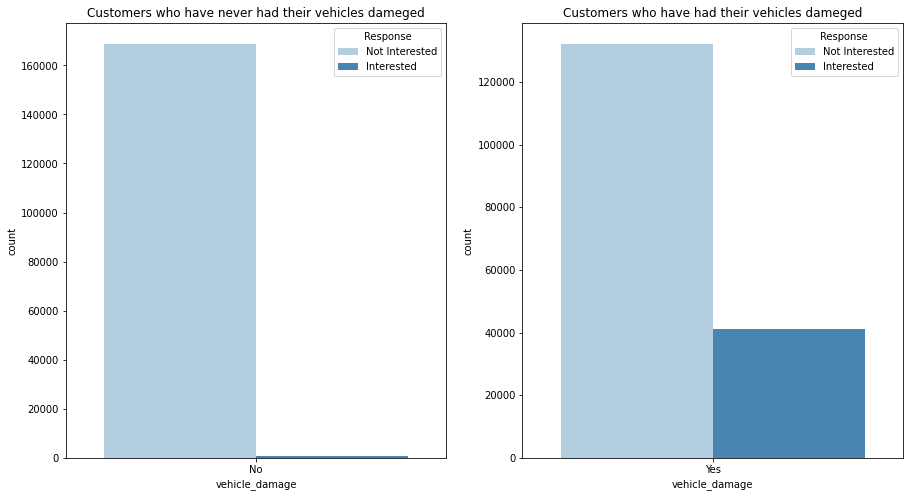

In [25]:
plt.figure(figsize = [15,8])
plt.subplot(1,2,1)
sns.countplot(x = 'vehicle_damage', hue = 'response', data = df3[df3['vehicle_damage'] == 'No'], palette = 'Blues')
plt.title('Customers who have never had their vehicles dameged')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])

plt.subplot(1,2,2)
sns.countplot(x = 'vehicle_damage', hue = 'response', data = df3[df3['vehicle_damage'] == 'Yes'], palette = 'Blues')
plt.title('Customers who have had their vehicles dameged')
plt.legend(title='Response',labels = ['Not Interested', 'Interested']);

Let's take a better look at the proportion:

In [35]:
print('Percentage of customers who have not had their vehicles damaged and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_damage'] == 'No']['response'].sum() / len(df3[df3['vehicle_damage'] == 'No'])*100))
print('Percentage of customers who have had their vehicles damaged and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_damage'] == 'Yes']['response'].sum() / len(df3[df3['vehicle_damage'] == 'Yes'])*100))

Percentage of customers who have not had their vehicles damaged and are interested in the insurance: 0.53%
Percentage of customers who have had their vehicles damaged and are interested in the insurance: 23.74%


### H4: Among women, the proportion of customers interested in purchasing the insurance is at least 10% higher than the proportion among men.
**<font color='red'>FALSE</font>**: even though it's a slightly difference, the proportion of customers interested in purchasing the insurance in higher among men. <br>

In [43]:
# checking the balance of the feature
df3['gender'].value_counts(normalize = True)

Male      0.540586
Female    0.459414
Name: gender, dtype: float64

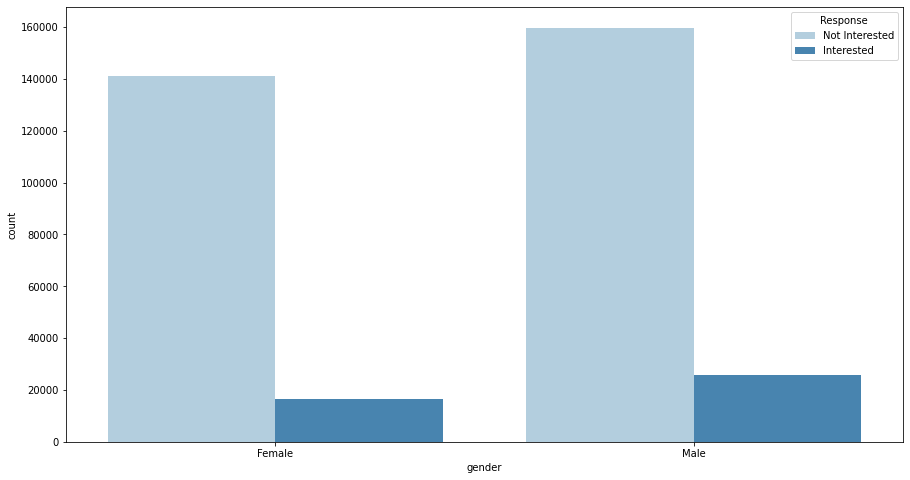

In [11]:
plt.figure(figsize = [15,8])
sns.countplot(x='gender', hue='response', data = df3, palette = 'Blues')
plt.legend(title='Response',labels = ['Not Interested', 'Interested']);

In [49]:
print('Percentage of men interested in the insurance: {:.2f}%'.format(df3[df3['gender'] == 'Male']['response'].sum() / len(df3[df3['gender'] == 'Male'])*100))
print('Percentage of women interested in the insurance: {:.2f}%'.format(df3[df3['gender'] == 'Female']['response'].sum() / len(df3[df3['gender'] == 'Female'])*100))

Percentage of men interested in the insurance: 13.84%
Percentage of women interested in the insurance: 10.39%


### H5: Among customers over the age of 60, those who have a vehicle older than 2 years are more interested in purchase the insurance.
**<font color='green'>TRUE</font>**: among those customers, about 21% of them are interested in purchasing the insurance, it's almost twice the proportion for the others vehicle age classes. <br>

In [59]:
df3['after_60'].value_counts()

0    300829
1     42169
Name: after_60, dtype: int64

In [78]:
aux = df3[df3['after_60'] == 1]

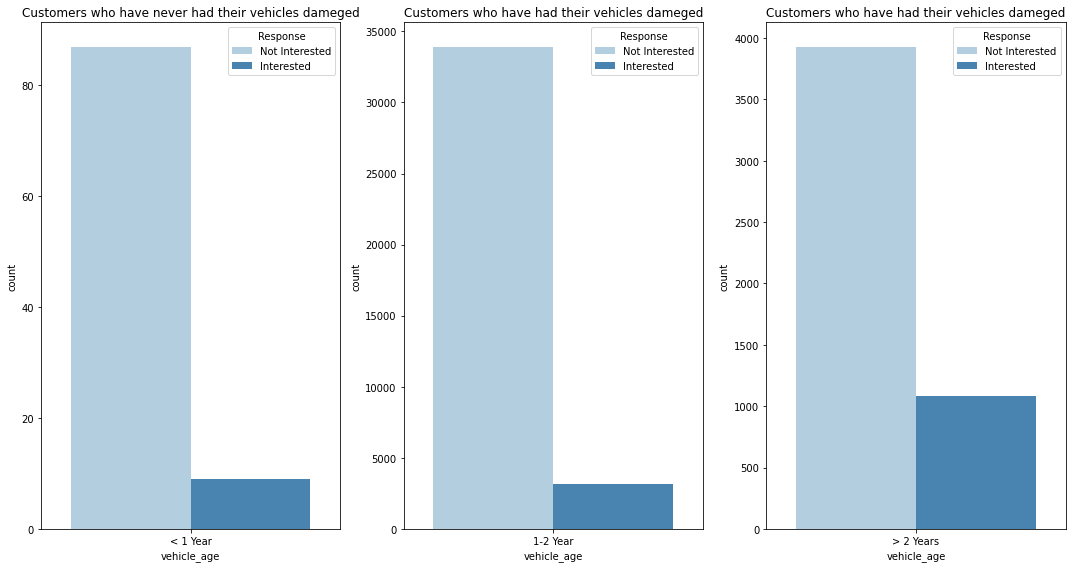

In [76]:
plt.figure(figsize = [15,8])
plt.subplot(1,3,1)
sns.countplot(x = 'vehicle_age', hue = 'response', data = aux[aux['vehicle_age'] == '< 1 Year'], palette = 'Blues')
plt.title('Customers who have never had their vehicles dameged')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])

plt.subplot(1,3,2)
sns.countplot(x = 'vehicle_age', hue = 'response', data = aux[aux['vehicle_age'] == '1-2 Year'], palette = 'Blues')
plt.title('Customers who have had their vehicles dameged')
plt.legend(title='Response',labels = ['Not Interested', 'Interested']);

plt.subplot(1,3,3)
sns.countplot(x = 'vehicle_age', hue = 'response', data = aux[aux['vehicle_age'] == '> 2 Years'], palette = 'Blues')
plt.title('Customers who have had their vehicles dameged')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])
plt.tight_layout();

In [77]:
print('Percentage of customers over the age of 60 who have a vehicle newer than 1 year and are interested in the insurance: {:.2f}%'.format(aux[aux['vehicle_age'] == '< 1 Year']['response'].sum() / len(aux[aux['vehicle_age'] == '< 1 Year'])*100))
print('Percentage of customers over the age of 60 who have a vehicle aged between 1 and 2 years and are interested in the insurance: {:.2f}%'.format(aux[aux['vehicle_age'] == '1-2 Year']['response'].sum() / len(aux[aux['vehicle_age'] == '1-2 Year'])*100))
print('Percentage of customers over the age of 60 who have a vehicle older than 2 years and are interested in the insurance: {:.2f}%'.format(aux[aux['vehicle_age'] == '> 2 Years']['response'].sum() / len(aux[aux['vehicle_age'] == '> 2 Years'])*100))

Percentage of customers over the age of 60 who have a vehicle newer than 1 year and are interested in the insurance: 9.38%
Percentage of customers over the age of 60 who have a vehicle aged between 1 and 2 years and are interested in the insurance: 8.43%
Percentage of customers over the age of 60 who have a vehicle older than 2 years and are interested in the insurance: 21.55%


### H6: The proportion of customers interested in purchase the insurance is at least 10% higher among those who are customers for more than 6 months.
**<font color='red'>FALSE</font>**: the proportion of interested among the two groups is almost the same. <br>

In [20]:
print('{:.2f}% of of those who are customers for less than six months are interested in purchasing the insurance'.format(df3[df3['vintage_months'] <= 6]['response'].sum()/len(df3[df3['vintage_months'] <= 6])*100))
print('{:.2f}% of of those who are customers for more than six months are interested in purchasing the insurance'.format(df3[df3['vintage_months'] >= 6]['response'].sum()/len(df3[df3['vintage_months'] >= 6])*100))

12.23% of of those who are customers for less than six months are interested in purchasing the insurance
12.30% of of those who are customers for more than six months are interested in purchasing the insurance


In [19]:
print('{:.2f}% of of those who are customers for more than six months are interested in purchasing the insurance'.format(df3[df3['vintage_months'] <= 6]['response'].sum()/len(df3[df3['vintage_months'] <= 6])*100))

12.23% of of those who are customers for more than six months are interested in purchasing the insurance


### H7: Customers who spent above the average in premiums are more interested in purchasing the insurance.
**<font color='green'>TRUE</font>**: even though the difference is not too large, customers who spent above the average in premiums are more insterested in purchasing the insurance than customers who spent below the average. <br>

In [21]:
print('{:.2f}% of customers who spent bellow the average in premiums are interested in purchasing the insurance.'.format(df3[df3['annual_premium'] <= df3['annual_premium'].mean()]['response'].sum()/len(df3[df3['annual_premium'] <= df3['annual_premium'].mean()])*100))
print('{:.2f}% of customers who spent above the average in premiums are interested in purchasing the insurance.'.format(df3[df3['annual_premium'] >= df3['annual_premium'].mean()]['response'].sum()/len(df3[df3['annual_premium'] >= df3['annual_premium'].mean()])*100))

11.15% of customers who spent bellow the average in premiums are interested in purchasing the insurance.
13.20% of customers who spent above the average in premiums are interested in purchasing the insurance.


### H8: Customers who spent above the average in less time as a customer are more interested in purchasing the vehicle insurance than those who spent below the average in less time.
**<font color='green'>TRUE</font>**: the proportion of customers who spent above the average in 3 months and are interested in purchasing the insurance is almost 2% higher than the customers who spent below the average and are interested<br>

In [88]:
# let's consider 'less time' as 3 months as a customer
aux1 = df3[(df3['annual_premium'] > df3['annual_premium'].mean()) & (df3['vintage_months'] <= 3)]
aux2 = df3[(df3['annual_premium'] <= df3['annual_premium'].mean()) & (df3['vintage_months'] <= 3)]

In [87]:
print('{:.2f}% of customers who spent above the average in less time and are interested in purchasing the insurance.'.format(aux1['response'].sum() / len(aux1['response'])*100))
print('{:.2f}% of customers who spent below the average in less time and are interested in purchasing the insurance.'.format(aux2['response'].sum() / len(aux2['response'])*100))

13.02% of customers who spent above the average in less time and are interested in purchasing the insurance.
11.37% of customers who spent below the average in less time and are interested in purchasing the insurance.


### H9: There are more customers interested in purchasing the insurance among those who have a vehicle newer than 1 year.
**<font color='red'>FALSE</font>**: the interest in purchasing the vehicle insurance is higher among customers who have a car aged over 2 years than than the others vehicle age classes. <br>

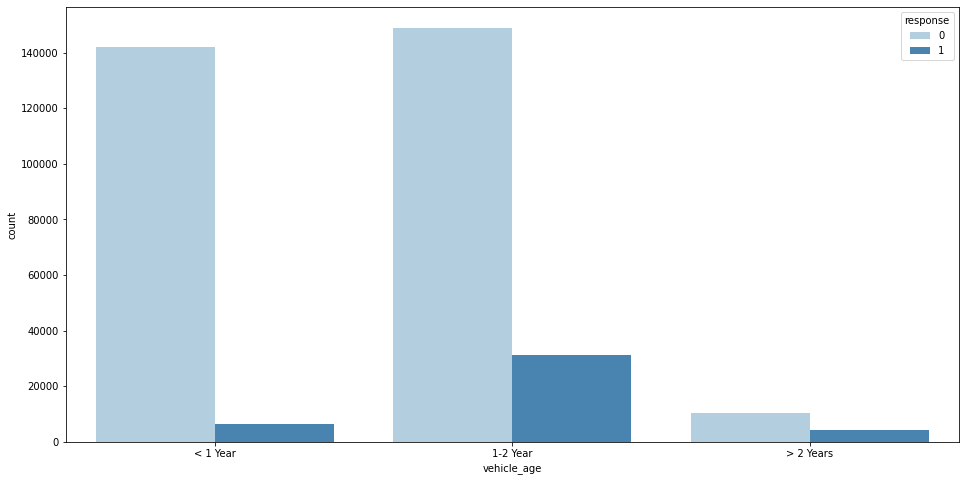

In [115]:
plt.figure(figsize=[16,8])
sns.countplot(x = 'vehicle_age', hue = 'response', data=df3, palette = 'Blues');

In [114]:
print('Percentage of customers who have a car aged less than 1 year and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_age'] == '< 1 Year']['response'].sum() / len(df3[df3['vehicle_age'] == '< 1 Year'])*100))
print('Percentage of customers who have a car aged between 1 and 2 years and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_age'] == '1-2 Year']['response'].sum() / len(df3[df3['vehicle_age'] == '1-2 Year'])*100))
print('Percentage of customers who have a car over 2 years old and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_age'] == '> 2 Years']['response'].sum() / len(df3[df3['vehicle_age'] == '> 2 Years'])*100))

Percentage of customers who have a car aged less than 1 year and are interested in the insurance: 4.40%
Percentage of customers who have a car aged between 1 and 2 years and are interested in the insurance: 17.37%
Percentage of customers who have a car over 2 years old and are interested in the insurance: 29.18%


### H10: There are more customers interested in purchasing the insurance among those who have never had a vehicle insurance.
**<font color='green'>TRUE</font>**: customers who do not have or have never had a vehicle insurance are more interested in purchasing the insurance.<br>

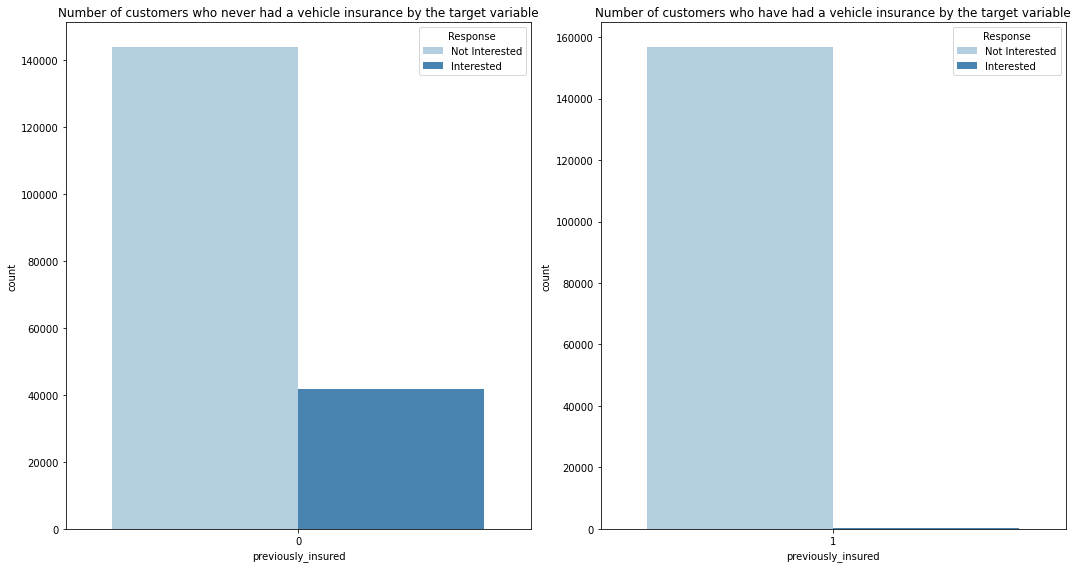

In [116]:
plt.figure(figsize = [15,8])

plt.subplot(1,2,1)
sns.countplot(x = 'previously_insured', hue = 'response', data = df3[df3['previously_insured'] == 0], palette = 'Blues')
plt.title('Number of customers who never had a vehicle insurance by the target variable')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])

plt.subplot(1,2,2)
sns.countplot(x = 'previously_insured', hue = 'response', data = df3[df3['previously_insured'] == 1], palette = 'Blues')
plt.title('Number of customers who have had a vehicle insurance by the target variable')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])
plt.tight_layout();

Since we can't clearly see the differences in the second chart, let's take a look at the proportions.

In [22]:
print('Percentage of customers who do not have or have never had a vehicle insurance and are interested in the insurance: {:.2f}%'.format(df3[df3['previously_insured'] == 0]['response'].sum() / len(df3[df3['previously_insured'] == 0])*100))
print('Percentage of customers who have/have had a vehicel insurance and are interested in the insurance: {:.2f}%'.format(df3[df3['previously_insured'] == 1]['response'].sum() / len(df3[df3['previously_insured'] == 1])*100))

Percentage of customers who do not have or have never had a vehicle insurance and are interested in the insurance: 22.54%
Percentage of customers who have/have had a vehicel insurance and are interested in the insurance: 0.09%


### H11: Customers from regions that have a higher mean in premium spending are more interested in purchasing the insurance.
**<font color='green'>TRUE</font>**: customers who do not have or have never had a vehicle insurance are more interested in purchasing the insurance.<br>

In [33]:
print('{:.2f}% of customers from region that spent below the average in premium are interested in purchasing the insurance'.format(df3[df3['region_premium'] <= df3['annual_premium'].mean()]['response'].sum() / len(df3[df3['region_premium'] <= df3['annual_premium'].mean()])*100))
print('{:.2f}% of customers from region that spent above the average in premium are interested in purchasing the insurance'.format(df3[df3['region_premium'] >= df3['annual_premium'].mean()]['response'].sum() / len(df3[df3['region_premium'] >= df3['annual_premium'].mean()])*100))

9.78% of customers from region that spent below the average in premium are interested in purchasing the insurance
15.28% of customers from region that spent above the average in premium are interested in purchasing the insurance


### 4.2.1 Hypothesis Validation Summary

| Hypothesis | Validation |
| --- | --- |
| H1 | <font color='green'>True</font> |
| H2 | <font color='red'>False</font> |
| H3 | <font color='red'>False</font> |
| H4 | <font color='red'>False</font> |
| H5 | <font color='green'>True</font> |
| H6 | <font color='red'>False</font> |
| H7 | <font color='green'>True</font> |
| H8 |  <font color='green'>True</font> |
| H9 | <font color='red'>False</font> |
| H10 |  <font color='green'>True</font> |
| H11 |  <font color='green'>True</font> |

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Features + Target

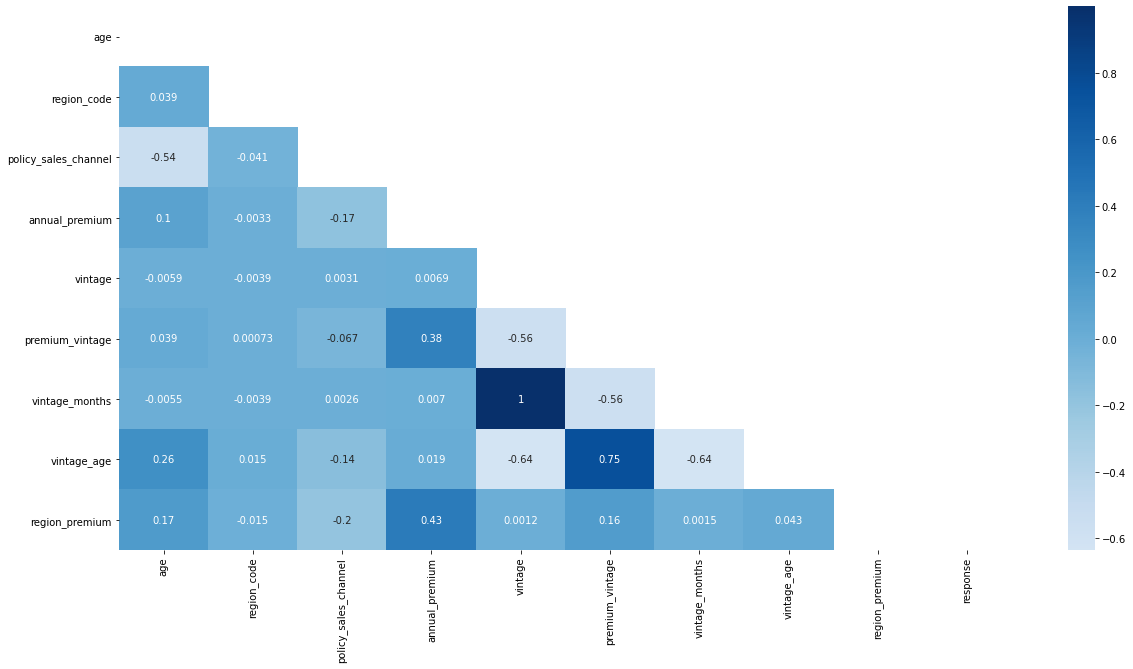

In [93]:
# calculating pearson correlations
df_corr = num_attributes.corr(method = 'pearson')

# calculating point-biserial correlations
interest = []
for i, j in enumerate(num_attributes.columns):
    result = ss.pointbiserialr(num_attributes[f'{j}'], cat_attributes['response'])[0]
    interest.append(result)
    if i == 9:
        df_corr.loc['response'] = interest
        interest.append(1)
df_corr['response'] = interest

## plotting
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (20,10))
sns.heatmap(df_corr,cmap='Blues',mask = mask,annot=True, 
            center = 0,);

### 4.3.2. Categorical Features + Target

In [99]:
cat_attributes.head()

,driving_license,vehicle_age,vehicle_damage,previously_insured,after_60,gender,response
0,1,1,1,0,0,male,1
1,1,1,1,0,0,female,0
2,1,1,0,1,0,male,0
3,1,1,1,0,0,male,0
4,1,2,1,0,0,male,1


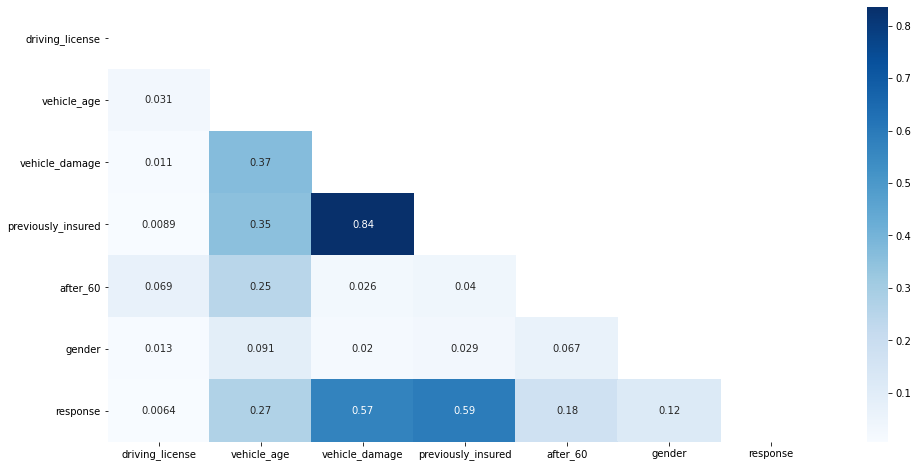

In [100]:
# changing attriutes type so the Cramér-V function doesn't return an error
cat_attributes['driving_license'] = cat_attributes['driving_license'].map({1: 'yes', 0:'no' })
cat_attributes['previously_insured'] = cat_attributes['previously_insured'].map({1: 'yes', 0:'no' })
cat_attributes['response'] = cat_attributes['response'].map({1: 'yes', 0:'no' })
cat_attributes['vehicle_age'] = cat_attributes['vehicle_age'].map({1: '< 1 Year', 2:'1-2 Year', 3: '> 2 Years ' })
cat_attributes['after_60'] = cat_attributes['after_60'].map({1: 'yes', 0:'no' })
cat_attributes['vehicle_damage'] = cat_attributes['vehicle_damage'].map({1: 'yes', 0:'no' })

cat_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # calculating the correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # appending to the list
        corr_list.append(corr)
    
    corr_dict[ref] = corr_list

cat_corr = pd.DataFrame(corr_dict)
cat_corr = cat_corr.set_index(cat_corr.columns)
mask = np.zeros_like( cat_corr, dtype=np.bool )
mask[np.triu_indices_from( mask )] = True

plt.subplots(figsize = (16,8))
sns.heatmap(cat_corr, cmap='Blues', mask = mask, annot=True);

# 5.0. STEP 5: DATA PREPARATION

In [2]:
df5 = pickle.load(open('../data/temp/df2_balanced.pkl', 'rb'))

## 5.1. Standardization

In [3]:
ss_ap = StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss_ap.fit_transform(df5[['annual_premium']].values)

## 5.2. Rescaling

In [4]:
mms_age = MinMaxScaler()
mms_vin = MinMaxScaler()
mms_pre_vin = MinMaxScaler()
mms_vin_mon = MinMaxScaler()
mms_vin_age = MinMaxScaler()
mms_reg_pre = MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vin.fit_transform( df5[['vintage']].values )

# premium_vintage
df5['premium_vintage'] = mms_pre_vin.fit_transform( df5[['premium_vintage']].values )

# vintage_months
df5['vintage_months'] = mms_vin_mon.fit_transform( df5[['vintage_months']].values )

# vintage_age
df5['vintage_age'] = mms_vin_age.fit_transform( df5[['vintage_age']].values )

# region_premium
df5['region_premium'] = mms_reg_pre.fit_transform( df5[['region_premium']].values )

## 4.2. Encoding

In [5]:
# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

# region_code - Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# gender - One Hot Encoding
df5[['male', 'female']] = pd.get_dummies(df5['gender'])

## 5.3. Validation Dataset Preparation

In [6]:
df_val = pickle.load(open('../data/temp/test_dataset.pkl', 'rb'))

### 5.3.1. Feature Engineering

In [7]:
df_val['premium_vintage'] = df_val['annual_premium'] / df_val['vintage']

df_val['after_60'] = df_val.apply( lambda x: 0 if x['age'] < 60 else 1, axis = 1)

df_val['vintage_months'] = df_val['vintage']/30

df_val['vintage_age'] = df_val['age']*365 / df_val['vintage']

df_val['region_premium'] = 0
for index, code in zip(df_val.index, df_val['region_code']):
    df_val['region_premium'].iloc[index] = df_val[df_val['region_code'] == code]['annual_premium'].mean()

'''X_val['policy_premium'] = 0
for index, code in zip(df2.index, df2['policy_sales_channel']):
    df2['policy_premium'].iloc[index] = df2[df2['policy_sales_channel'] == code]['annual_premium'].mean()'''

"X_val['policy_premium'] = 0\nfor index, code in zip(df2.index, df2['policy_sales_channel']):\n    df2['policy_premium'].iloc[index] = df2[df2['policy_sales_channel'] == code]['annual_premium'].mean()"

### 5.3,2. Preparation

In [8]:
df_val['vehicle_damage'] = df_val['vehicle_damage'].map( {'Yes':1, 'No':0})
df_val['vehicle_age'] = df_val['vehicle_age'].map( {'< 1 Year':1, '1-2 Year':2, '> 2 Years':3})

In [9]:
# annual_premium
df_val.loc[:, 'annual_premium'] = ss_ap.transform( df_val[['annual_premium']].values )

# age
df_val.loc[:, 'age'] = mms_age.transform( df_val[['age']].values )

# vintage
df_val.loc[:, 'vintage'] = mms_vin.transform( df_val[['vintage']].values )

# premium_vintage
df_val.loc[:, 'premium_vintage'] = mms_pre_vin.transform( df_val[['premium_vintage']].values )

# vintage_months
df_val.loc[:, 'vintage_months'] = mms_vin_mon.transform( df_val[['vintage_months']].values )

# vintage_age
df_val.loc[:, 'vintage_age'] = mms_vin_age.transform( df_val[['vintage_age']].values )

# region_premium
df_val.loc[:, 'region_premium'] = mms_reg_pre.transform( df_val[['region_premium']].values )


# gender
df_val[['male', 'female']] = pd.get_dummies(df_val['gender'])

# region_code
df_val.loc[:, 'region_code'] = df_val.loc[:, 'region_code'].map( target_encode_region_code )

# policy_sales_channel
df_val.loc[:, 'policy_sales_channel'] = df_val['policy_sales_channel'].map( fe_policy_sales_channel )

# fillna
#df_val = df_val.fillna( 0 )

In [10]:
pickle.dump( df5, open( '../data/temp/df5.pkl', 'wb') )
pickle.dump( df_val, open( '../data/temp/df_val.pkl', 'wb') ) 

## 5.4. Splitting features and target

In [11]:
X_train = df5.drop(['response', 'gender'], axis = 1)
y_train = df5['response'].copy()

X_val = df_val.drop(['response', 'gender', 'id'], axis = 1)
y_val = df_val['response'].copy()

# 6.0. STEP 6: FEATURE SELECTION

## 6.1. Boruta Feature Selector

In [67]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

In [68]:
# define RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1)
#extra = ExtraTreesClassifier(n_jobs=-1)
#xgb = XGBClassifier(max_depth=2, random_state=42)

# define Boruta
boruta = BorutaPy(rf, verbose=1, n_estimators='auto', random_state=42)
boruta.fit(X_train_n, y_train_n)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100


BorutaPy finished running.

Iteration: 	33 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	8


BorutaPy(estimator=RandomForestClassifier(n_estimators=42, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1C699FD4E40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1C699FD4E40, verbose=1)

In [71]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop(['response', 'gender'], axis = 1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2. Feature Importance

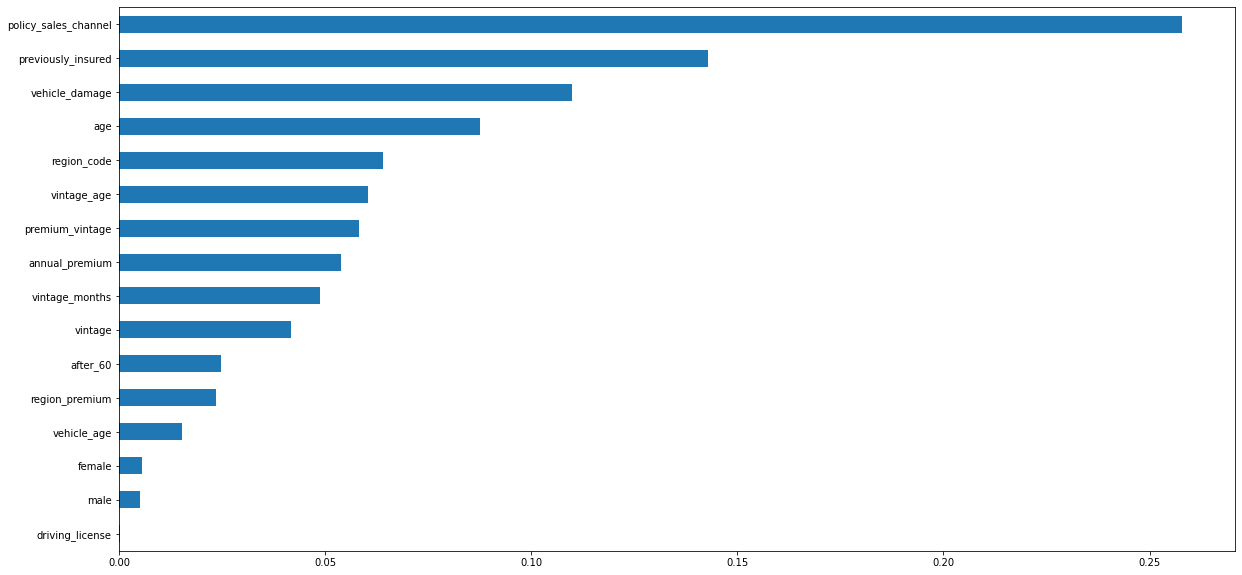

In [73]:
#feature importances 
rf_model = RandomForestClassifier(n_jobs = -1, random_state = 6)
rf_model.fit(X_train, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

plt.subplots(figsize = (20,10))
feat_importances.sort_values().plot(kind='barh');

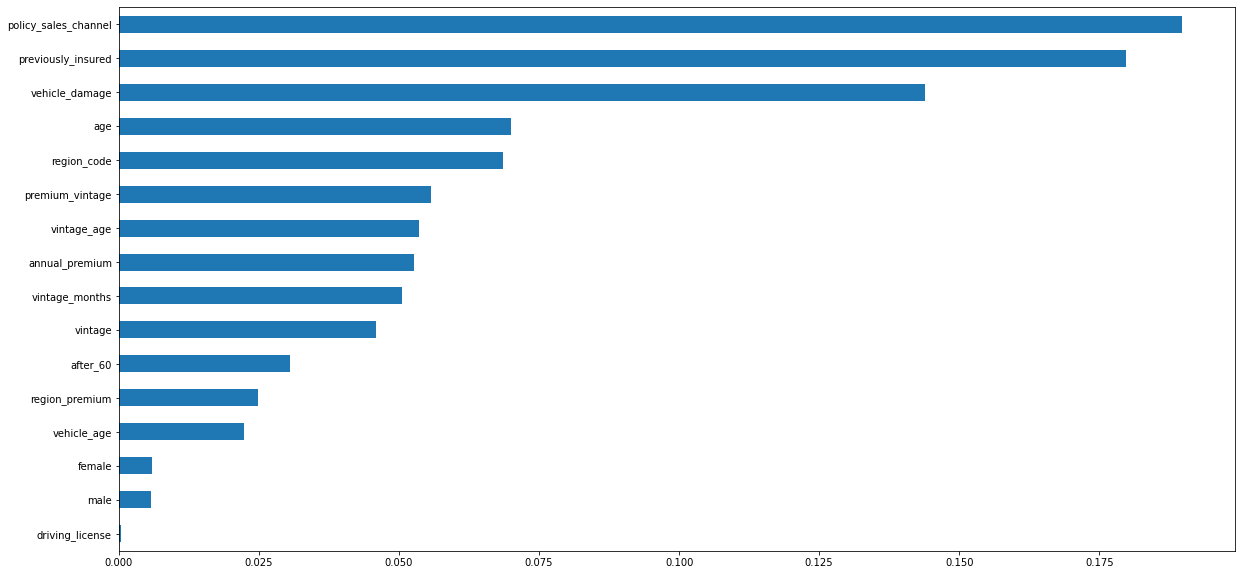

In [75]:
ext_clf = ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)
ext_clf.fit(X_train, y_train)

feat_importances = pd.Series(ext_clf.feature_importances_, index=X_train.columns)

plt.subplots(figsize = (20,10))
feat_importances.sort_values().plot(kind='barh');

# 7.0. STEP 7: MACHINE LEARNING MODELING

Models to be used:
- KNN Classifier
- Logistic Regression
- SGD Classifier
- Random Forest Classifier
- XGBoost Classifier
- LGBM Classifier

In [2]:
df5 = pickle.load(open('../data/temp/df5.pkl', 'rb'))
df_val = pickle.load(open('../data/temp/df_val.pkl', 'rb'))

In [3]:
cols_selected = ['age',
 'region_code',
 'policy_sales_channel',
 'vehicle_damage',
 'previously_insured',
 'premium_vintage',
 'vintage_months',
 'vintage_age']

In [4]:
X_train = df5[cols_selected].copy()
y_train = df5['response']

X_val = df_val[cols_selected].copy()
y_val = df_val['response']

## 7.1. Modeling

### 7.1.1. KNN CLassifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier
# model definition
knn_model = KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( X_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( X_val )

In [6]:
pickle.dump( knn_model, open( '../src/models/knn_model.pkl', 'wb' ) )

### 7.1.2. Logistic Regression

In [18]:
# model definition
lr_model = LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( X_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( X_val )

In [23]:
pickle.dump( lr_model, open( '../src/models/lr_model.pkl', 'wb' ) )

### 7.1.3. SGD Classifier

In [19]:
# model definition
sgd_model = SGDClassifier(loss='log', random_state=42, n_jobs=-1)

# model training
sgd_model.fit( X_train, y_train )

# model prediction
yhat_sgd = sgd_model.predict_proba( X_val )

In [26]:
pickle.dump( sgd_model, open( '../src/models/sgd_model.pkl', 'wb' ) )

### 7.1.4. Random Forest Classifier

In [10]:
# model definition
rf_model = RandomForestClassifier(n_estimators=500, n_jobs=1, random_state=42) 

# model training
rf_model.fit(X_train, y_train)

# model prediction
yhat_rf = rf_model.predict_proba(X_val)

In [11]:
pickle.dump( rf_model, open( '../src/models/rf_model.pkl', 'wb' ) )

### 7.1.5. XGB Classifier

In [20]:
# model definition
xgb_model = XGBClassifier(random_state=42)

# model training
xgb_model.fit( X_train, y_train )

# model prediction
yhat_xgb = xgb_model.predict_proba( X_val )

In [9]:
pickle.dump( xgb_model, open( '../src/models/xgb_model.pkl', 'wb' ) )

### 7.1.6. LGBM Classifier

In [21]:
# model definition
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-42)

# model training
lgbm_model.fit( X_train, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( X_val )

In [29]:
pickle.dump( lgbm_model, open( '../src/models/lgbm_model.pkl', 'wb' ) )

## 7.2. Gain and Lift Curves

In [12]:
knn_model  = pickle.load(open('../src/models/knn_model.pkl', 'rb'))
lr_model   = pickle.load(open('../src/models/lr_model.pkl', 'rb'))
sgd_model  = pickle.load(open('../src/models/sgd_model.pkl', 'rb'))
rf_model   = pickle.load(open('../src/models/rf_model.pkl', 'rb'))
xgb_model  = pickle.load(open('../src/models/xgb_model.pkl', 'rb'))
lgbm_model = pickle.load(open('../src/models/lgbm_model.pkl', 'rb'))

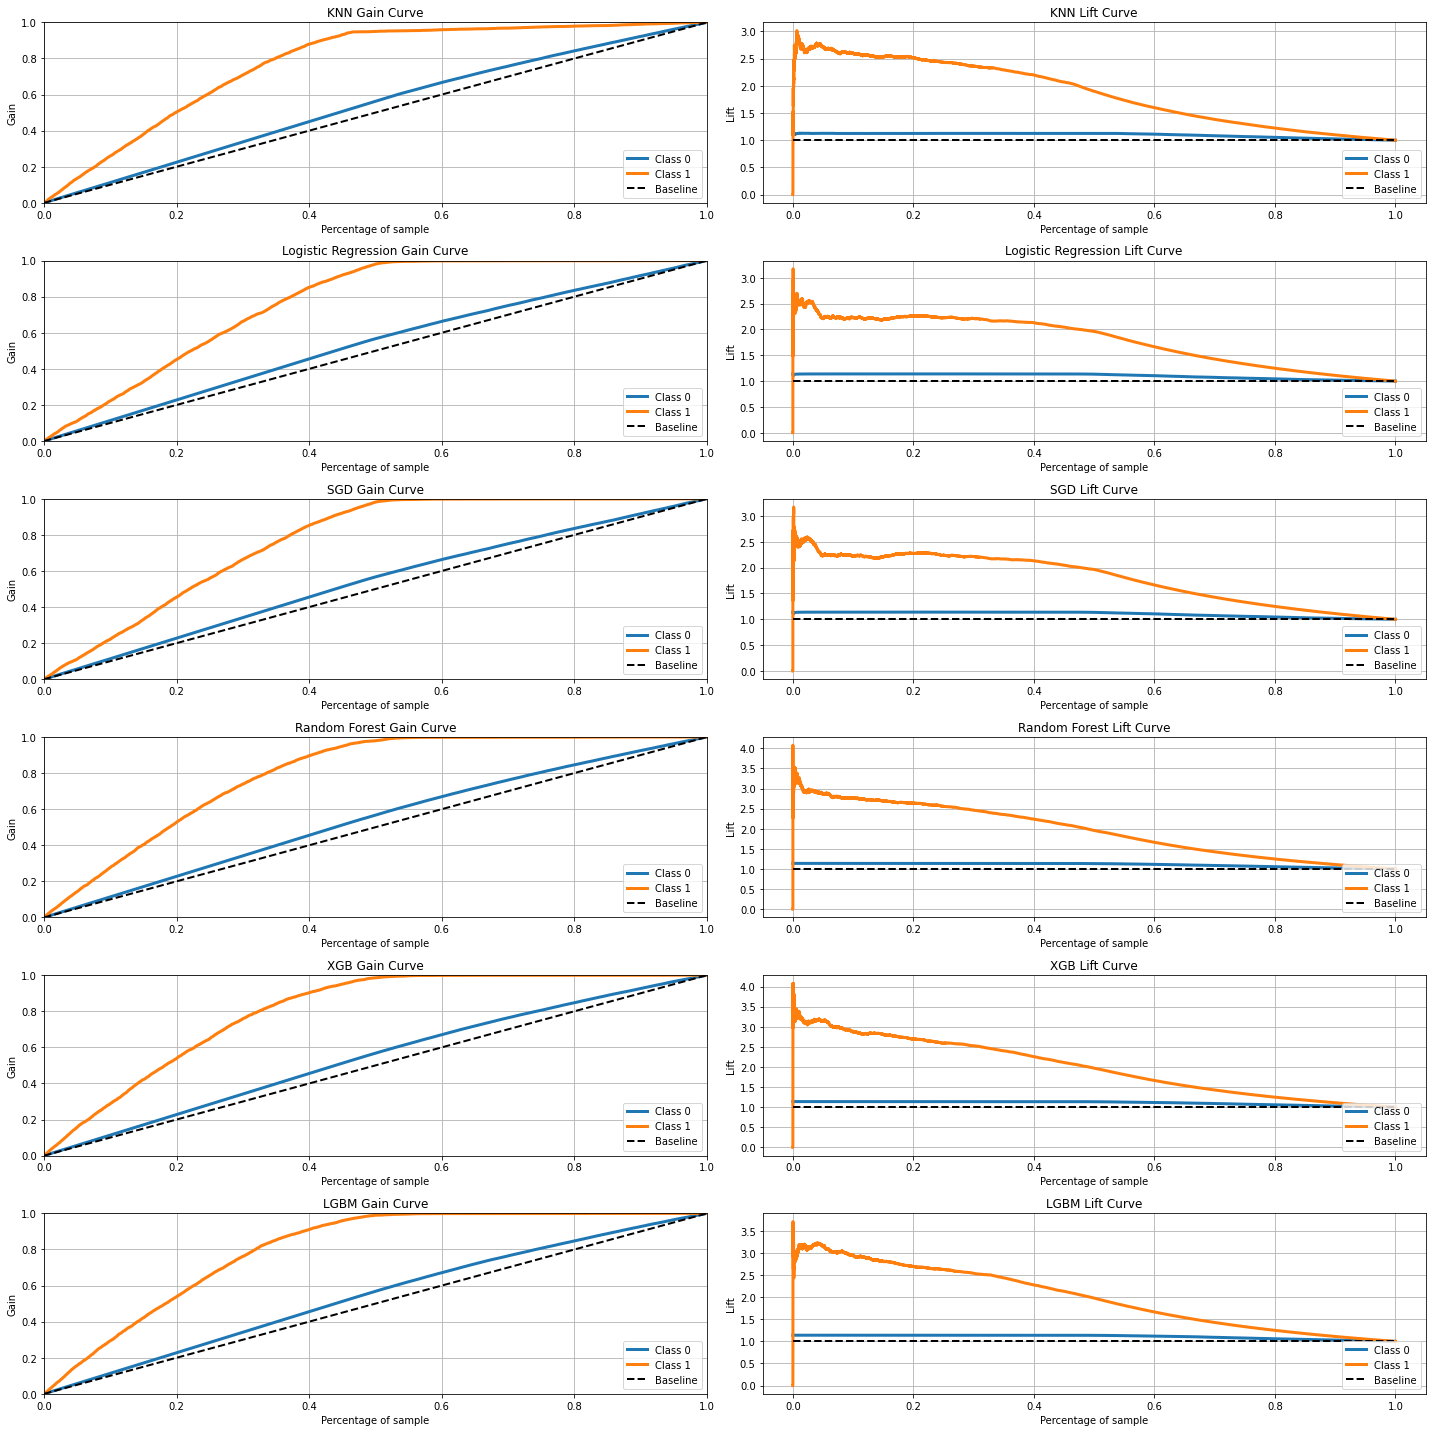

In [26]:
fig, ax = plt.subplots(6,2,figsize = (20,20))

skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, ax = ax[0,0], title = 'KNN Gain Curve' )
skplt.metrics.plot_lift_curve( y_val, yhat_knn, ax = ax[0,1], title = 'KNN Lift Curve' )

skplt.metrics.plot_cumulative_gain( y_val, yhat_lr, ax = ax[1,0], title = 'Logistic Regression Gain Curve' )
skplt.metrics.plot_lift_curve( y_val, yhat_lr, ax = ax[1,1], title = 'Logistic Regression Lift Curve' )

skplt.metrics.plot_cumulative_gain( y_val, yhat_sgd, ax = ax[2,0], title = 'SGD Gain Curve' )
skplt.metrics.plot_lift_curve( y_val, yhat_sgd, ax = ax[2,1], title = 'SGD Lift Curve' )

skplt.metrics.plot_cumulative_gain( y_val, yhat_rf, ax = ax[3,0], title = 'Random Forest Gain Curve' )
skplt.metrics.plot_lift_curve( y_val, yhat_rf, ax = ax[3,1], title = 'Random Forest Lift Curve' )

skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb, ax = ax[4,0], title = 'XGB Gain Curve' )
skplt.metrics.plot_lift_curve( y_val, yhat_xgb, ax = ax[4,1], title = 'XGB Lift Curve' )

skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm, ax = ax[5,0], title = 'LGBM Gain Curve' )
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm, ax = ax[5,1], title = 'LGBM Lift Curve' )
plt.tight_layout();